In [2]:
!pip install qutip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 72.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import scipy as sc
from scipy.special import erf
import scipy.constants as cn
import matplotlib.pyplot as plt
import time

from qutip import *

%matplotlib inline

## Parameters, Operators of two capacitively coupled Transmon

In [4]:
w1 = 6.245 * 2*np.pi         # GHz
w2 = 6.140 * 2*np.pi         # GHz
wd = w1

g12 = 10 * 1e-3              # GHz
eta = -150 * 1e-3 * 2*np.pi  # GHz

T1 = 5 * 1e3                # 比特相干时间 ns
Tphi = 5 * 1e3

Nq = 2; 

## Operators
a1 = tensor(destroy(Nq), qeye(Nq))
a2 = tensor(qeye(Nq), destroy(Nq))

sx1 = tensor( sigmax(), qeye(Nq))
sx2 = tensor(qeye(Nq), sigmax() )
sy1 = tensor( sigmay(), qeye(Nq))
sy2 = tensor(qeye(Nq), sigmay() )
sz1 = tensor( sigmaz(), qeye(Nq))
sz2 = tensor(qeye(Nq), sigmaz() )

sm1 = tensor( sigmap(), qeye(Nq))
sm2 = tensor(qeye(Nq), sigmap() )

## Drift Hamiltonian
H0 = -w1/2*sz1 - w2/2*sz2 + g12*(a1-a1.dag())*(a2-a2.dag())

## Pulse
For the envelope, a typical choice is Gaussian:
$$
s(t) = A \exp\left[-\left(\frac{t-t_{g}/2}{\sqrt{2\sigma}}\right)^{2}\right] \space, 0<t<t_{g},
$$
the corresponding $s^{\prime}(t)$ is:
$$
s^{\prime}(t)=A\frac{s(t)-s(-1)}{1-s(-1)}
$$

However, the Martinis group prefers the cosine-shaped evelopes for the nice property that their value and first derivative go to zero at the pulse boundaries:

$$
s(t)=\frac{A}{2}\left(1-\cos\frac{2\pi t}{t_{g}}\right),
$$
the corresponding $s^{\prime}(t)$ is:
$$
s^{\prime}(t)=-\frac{A}{2} \frac{\alpha}{\eta}\sin\frac{2\pi t}{t_{g}}
$$

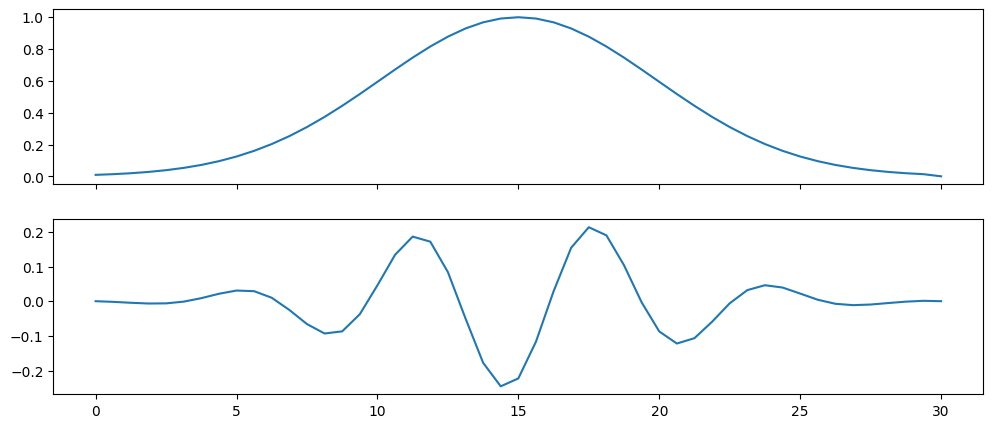

In [5]:
## Helper function for DRIVE pulse
def Gaussian(t, args):
    '''Gaussian waveform'''
    Tg = args['Tg']
    sigma = args['sigma']
    if t>=0 and t<Tg:
        return np.exp( -( (t-Tg/2)/np.sqrt(2*sigma) )**2 )
    else:
        return 0

def Hd_coeff(t, args):
    '''Gaussian pulse'''
    Tg = args['Tg']
    Amp = args['X_amp']
    phi0 = args['phi0']
    
    if t>=0 and t<Tg:
        A = Amp * Gaussian(t, args)
    else:
        A = 0
    return A*np.sin(wd*t+phi0)

## Pulse Parameters
T = 30
times = np.linspace(0, T, int(T/0.625)+1)

args = {'X_amp':0.25, 'Tg':T, 'alpha':1, 'phi0':0, 'sigma':0.8*T}


Gaussian_vec = np.vectorize(Gaussian)
Hd_coeff_vec = np.vectorize(Hd_coeff)

fig, axes = plt.subplots(2, 1, figsize = (12, 5), sharex=True)
axes[0].plot(times, Gaussian_vec(times, args))
axes[1].plot(times, Hd_coeff_vec(times, args))

## Dynamics

In [6]:
b00 = tensor(basis(Nq, 0), basis(Nq, 0))
b01 = tensor(basis(Nq, 0), basis(Nq, 1))
b10 = tensor(basis(Nq, 1), basis(Nq, 0))
b11 = tensor(basis(Nq, 1), basis(Nq, 1))

state_00_projecter = b00*b00.dag()
state_01_projecter = b01*b01.dag()
state_10_projecter = b10*b10.dag()
state_11_projecter = b11*b11.dag()

psi0 = b00

Hamiltonian = [ H0, [sx1, Hd_coeff]]

e_ops = [sx1, sy1, sz1]

c_ops = []
c_ops.append(np.sqrt(1/T1)*a1)
c_ops.append(np.sqrt(1/T1)*a2)

In [7]:
options=Options(rhs_with_state=True, store_states=True, nsteps=8000) #, atol=10e-12, rtol=1e-8)
result = mesolve(Hamiltonian, psi0, times, c_ops, e_ops, args=args, progress_bar=True,\
                 options=options)

states = result.states

10.2%. Run time:   0.07s. Est. time left: 00:00:00:00
20.4%. Run time:   0.12s. Est. time left: 00:00:00:00
30.6%. Run time:   0.17s. Est. time left: 00:00:00:00
40.8%. Run time:   0.22s. Est. time left: 00:00:00:00
51.0%. Run time:   0.30s. Est. time left: 00:00:00:00
61.2%. Run time:   0.34s. Est. time left: 00:00:00:00
71.4%. Run time:   0.39s. Est. time left: 00:00:00:00
81.6%. Run time:   0.47s. Est. time left: 00:00:00:00
91.8%. Run time:   0.60s. Est. time left: 00:00:00:00
Total run time:   0.68s


## Plot the state evolution

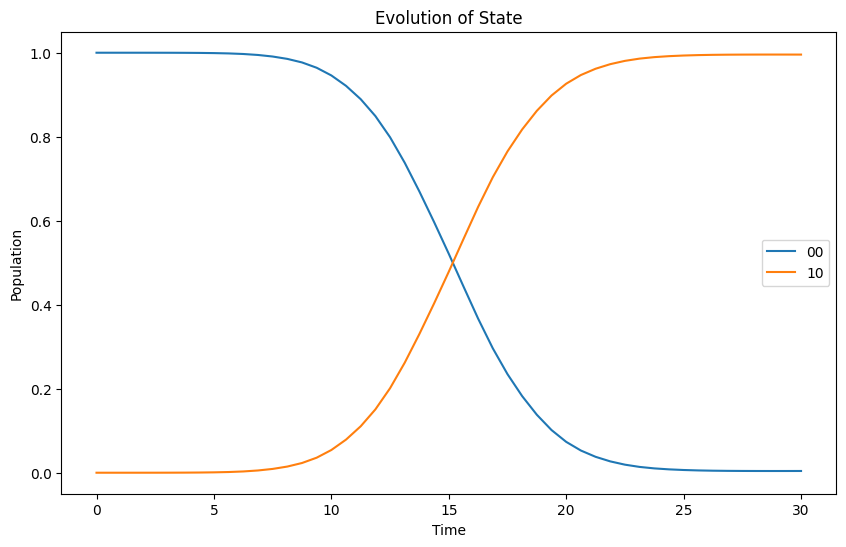

In [8]:
def state_population_plot(result,t_list,state_text):
    population_00 = expect(state_00_projecter, result.states)
    population_01 = expect(state_01_projecter, result.states)
    population_10 = expect(state_10_projecter, result.states)
    population_11 = expect(state_11_projecter, result.states)

    plt.figure(figsize=(6, 4))
    plt.plot(t_list, population_00, label = '00')
    #plt.plot(t_list, population_01, label = '01')
    plt.plot(t_list, population_10, label = '10')
    #plt.plot(t_list, population_11, label = '11')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title('Evolution of State'+state_text)
    plt.legend()
    plt.show()

state_population_plot(result, times, '')

In [9]:
fidelity(states[-1], b10)

0.9977809852566917

## Calibration of Amplitude

In [10]:
database = {'X_amp':None, 'Tg':T, 'alpha':1, 'phi0':0, 'sigma':0.8*T}
amp_list = np.linspace(0, 1.2, 121)

def amp_calibrate(amp_list):
    '''Simulate the experimental calibration of pi-pulse amplitude'''
    P0_data = []
    P1_data = []
    for amp in amp_list:
        args = {'X_amp':amp, 'Tg':T, 'alpha':1, 'phi0':0, 'sigma':0.8*T}
        result = mesolve(Hamiltonian, psi0, times, c_ops, e_ops, args=args, progress_bar=True,\
                 options=options)
        P1 = expect(state_10_projecter, result.states[-1])
        P0 = expect(state_00_projecter, result.states[-1])
        P1_data.append(P1)
        P0_data.append(P0)
    
    return P0_data, P1_data

from scipy.signal import find_peaks
def amp_update(P1_data):
    peaks, dic = find_peaks(P1_data)
    p = peaks[0]
    database['X_amp'] = amp_list[p]
    print('The optimal amp is:', amp_list[p], ', corresponding to P1:', P1_data[p])
    print('The database is updated:')
    print(database)

In [11]:
begin_time = time.time()
P0, P1 = amp_calibrate(amp_list)
end_time = time.time()
print('')
print(end_time-begin_time, 's')

10.2%. Run time:   0.02s. Est. time left: 00:00:00:00
20.4%. Run time:   0.04s. Est. time left: 00:00:00:00
30.6%. Run time:   0.06s. Est. time left: 00:00:00:00
40.8%. Run time:   0.09s. Est. time left: 00:00:00:00
51.0%. Run time:   0.10s. Est. time left: 00:00:00:00
61.2%. Run time:   0.13s. Est. time left: 00:00:00:00
71.4%. Run time:   0.15s. Est. time left: 00:00:00:00
81.6%. Run time:   0.17s. Est. time left: 00:00:00:00
91.8%. Run time:   0.20s. Est. time left: 00:00:00:00
Total run time:   0.21s
10.2%. Run time:   0.02s. Est. time left: 00:00:00:00
20.4%. Run time:   0.04s. Est. time left: 00:00:00:00
30.6%. Run time:   0.06s. Est. time left: 00:00:00:00
40.8%. Run time:   0.08s. Est. time left: 00:00:00:00
51.0%. Run time:   0.10s. Est. time left: 00:00:00:00
61.2%. Run time:   0.13s. Est. time left: 00:00:00:00
71.4%. Run time:   0.16s. Est. time left: 00:00:00:00
81.6%. Run time:   0.19s. Est. time left: 00:00:00:00
91.8%. Run time:   0.22s. Est. time left: 00:00:00:00
Tota

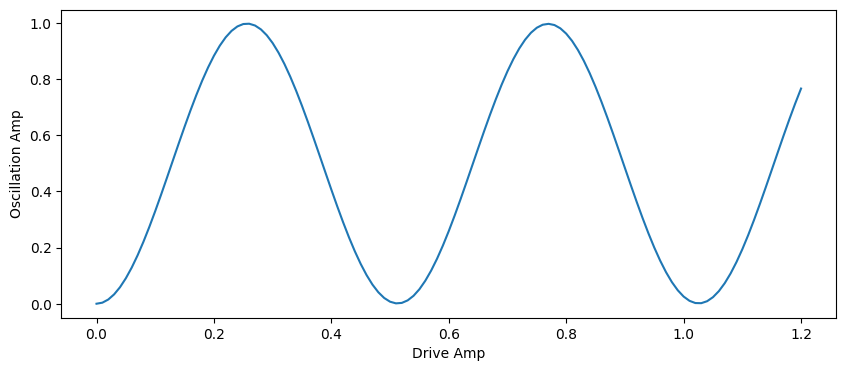

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(amp_list, P1)
plt.xlabel('Drive Amp')
plt.ylabel('Oscillation Amp')
plt.show()

In [13]:
amp_update(P1)

The optimal amp is: 0.26 , corresponding to P1: 0.9966585102661605
The database is updated:
{'X_amp': 0.26, 'Tg': 30, 'alpha': 1, 'phi0': 0, 'sigma': 24.0}


## Parallel Computation

In [ ]:
from qutip import parallel_map, parfor

P0_data = []
P1_data = []

def amp_calibrate2(amp):
    '''Simulate the experimental calibration of pi-pulse amplitude'''
    args = {'X_amp':amp, 'Tg':T, 'alpha':1, 'phi0':0, 'sigma':0.8*T}
    result = mesolve(Hamiltonian, psi0, times, c_ops, e_ops, args=args, progress_bar=True,\
                 options=options)
    P1 = expect(state_10_projecter, result.states[-1])
    P0 = expect(state_00_projecter, result.states[-1])
    P1_data.append(P1)
    P0_data.append(P0)

In [14]:
begin_time = time.time()
parallel_map(amp_calibrate2, amp_list)
end_time = time.time()
print('')
print(end_time-begin_time, 's')

10.2%. Run time:   0.06s. Est. time left: 00:00:00:0010.2%. Run time:   0.06s. Est. time left: 00:00:00:00

20.4%. Run time:   0.14s. Est. time left: 00:00:00:00
20.4%. Run time:   0.15s. Est. time left: 00:00:00:00
30.6%. Run time:   0.21s. Est. time left: 00:00:00:00
30.6%. Run time:   0.21s. Est. time left: 00:00:00:00
40.8%. Run time:   0.28s. Est. time left: 00:00:00:00
40.8%. Run time:   0.28s. Est. time left: 00:00:00:00
51.0%. Run time:   0.36s. Est. time left: 00:00:00:00
51.0%. Run time:   0.36s. Est. time left: 00:00:00:00
61.2%. Run time:   0.44s. Est. time left: 00:00:00:00
61.2%. Run time:   0.45s. Est. time left: 00:00:00:00
71.4%. Run time:   0.51s. Est. time left: 00:00:00:00
81.6%. Run time:   0.56s. Est. time left: 00:00:00:00
71.4%. Run time:   0.55s. Est. time left: 00:00:00:00
91.8%. Run time:   0.61s. Est. time left: 00:00:00:00
81.6%. Run time:   0.64s. Est. time left: 00:00:00:00Total run time:   0.65s

10.2%. Run time:   0.04s. Est. time left: 00:00:00:00
91.8

In [ ]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman and Simon Cross.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.0
Numpy Version:      1.21.0
Scipy Version:      1.7.0
Cython Version:     0.29.34
Matplotlib Version: 3.4.2
Python Version:     3.9.5
Number of CPUs:     8
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Windows (AMD64)
Installation path:  C:\Users\admin\anaconda3\envs\qutip-env\lib\site-packages\qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `